In [1]:
from __future__ import absolute_import, division, print_function
import glob
import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import pdb
import json
import getpass
from scipy import stats
from sklearn import linear_model
from numpy import linalg as LA
import numpy.random as npr
from sklearn.decomposition import PCA
import imageio
from sklearn.manifold import MDS
from scipy.spatial import distance
from sklearn.cluster import KMeans

ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
elif ui == 'lndrisco':
    p = '/home/users/lndrisco'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net)

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import name_best_ckpt, generate_Beta_epoch, make_h_combined, same_stim_trial
from tools_lnd import get_T_inds, gen_trials_from_model_dir

PATH_TO_RECURRENT_WHISPERER = p+'/code/recurrent-whisperer'#'/home/laura/code/recurrent-whisperer'#
sys.path.insert(0, PATH_TO_RECURRENT_WHISPERER)
from RecurrentWhisperer import RecurrentWhisperer

PATH_TO_FIXED_POINT_FINDER = p+'/code/fixed-point-finder' #'/home/laura/code/fixed-point-finder-experimental'#
sys.path.insert(0, PATH_TO_FIXED_POINT_FINDER)
from FixedPointFinder import FixedPointFinder

No display found. Using non-interactive Agg backend.


/Users/lauradriscoll/Documents/code/recurrent-whisperer/AdaptiveLearningRate.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance


In [2]:
task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'Decison1', 'Decison2', 'ContextDecison1', 'ContextDecison2', 'MultiDecison',
              'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
              'DelayMatch2SampleGo', 'DelayMatch2SampleNogo', 'DelayMatch2CategoryGo', 'DelayMatch2CategoryNoGo']

In [5]:
net = 'stepnet'
rule = 'delaygo'
fp_epoch = 'go1'
model_n = 0
# m = '/Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0'
dir_specific_all = net+'/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/'#net+'/crystals/softplus/l2w0001'#'crystals_no_noise/softplus/l2w0001/'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/#'lowD/grad_norm_l2001/most/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/
model_dir_all = os.path.join(p,'data/rnn/multitask/',dir_specific_all,str(model_n))
m = model_dir_all

model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


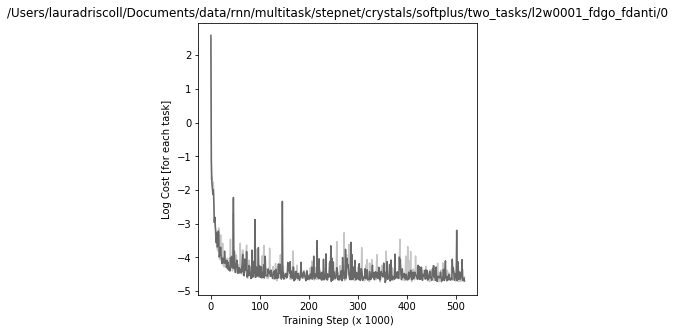

In [6]:
task_set = hparams['rule_trains']
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(model_dir_all, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_set)):
    c = cmap((r+1)/(len(task_set)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_set[r]])
    plt.plot(x,'-',c = c,label = task_set[r])
#     plt.plot(x,'o',c = c,label = task_set[r])
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
#     plt.ylim([-6,5])
    
plt.title(model_dir_all)
# plt.legend()
plt.show()  

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


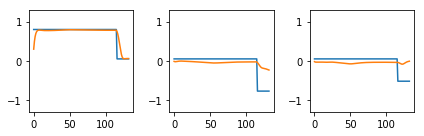

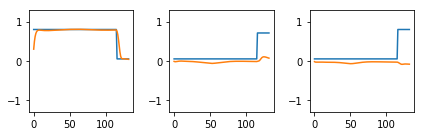

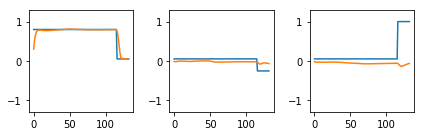

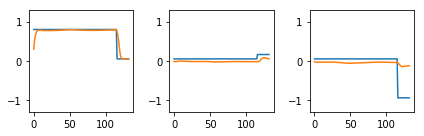

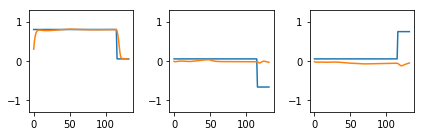

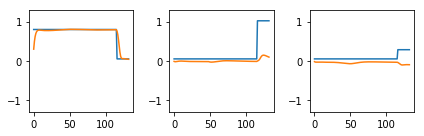

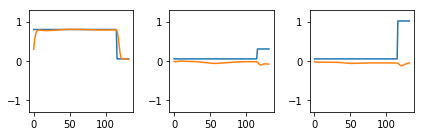

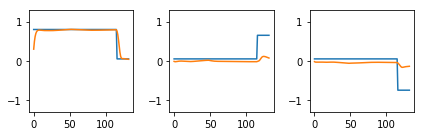

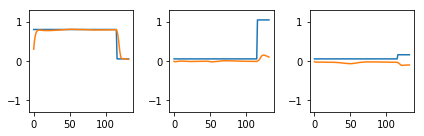

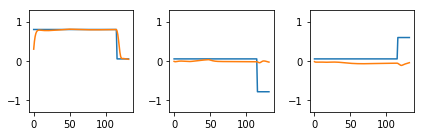

In [7]:
for tr in range(10):
    fig = plt.figure(figsize=(6,2),tight_layout=True,facecolor='white')
    for x in range(3):
        plt.subplot(1,3,x+1)
        plt.plot(trial.y[:,tr,x])
        plt.plot(np.dot(h_tf[:,tr,:],w_out[:,x]))
        plt.ylim((-1.3,1.3))
    plt.show()

In [7]:
# if activation == 'softplus':
#     _activation = lambda x: np.log(np.exp(x) + 1)
# elif activation == 'tanh':
#     _activation = lambda x: np.tanh(x)
# elif activation == 'relu':
#     _activation = lambda x: x * (x > 0)
# elif activation == 'power':
#     _activation = lambda x: (x * (x > 0))**2
# elif activation == 'retanh':
#     _activation = lambda x: np.tanh(x * (x > 0))

# def out_affine(params, h):
#     return np.dot(params[2].T,h)+params[3]

In [8]:
def gen_X_from_model_dir(model_dir,trial):
    model = Model(model_dir)
    with tf.Session() as sess:
        model.restore()
        # model._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        hparams = model.hp
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        # run model
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        x = np.transpose(h_tf,(2,1,0)) # h_tf[:,range(1,n_trials),:],(2,1,0))
        X = np.reshape(x,(x.shape[0],-1))
    return X, x 

In [9]:
def make_axes(m,rule_master,epoch,ind = -1,mod = 'either'):

    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        trial_master = generate_trials(rule_master, hparams, mode = 'test', batch_size = 400, noise_on=False, delay_fac =1)
        feed_dict = tools.gen_feed_dict(model, trial_master, hparams)
        h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)

    print(mod)
    Beta_epoch = generate_Beta_epoch(h_tf,trial_master,ind,mod = mod)
    X_pca = Beta_epoch[epoch]    
    D = np.concatenate((np.expand_dims(X_pca[:,0],axis=1),np.expand_dims(X_pca[:,1],axis=1)),axis = 1)
    return D

In [10]:
def plot_h_mds_steps(X_transformed,n_interp,nfps,dot_alpha = .3):
    cmap=plt.get_cmap('plasma')
        
    for ri in range(n_interp):
        c = cmap(ri/n_interp)
        X_trial = X_transformed[(ri*nfps):((ri+1)*nfps),:]
        plt.plot(X_trial[:,0],X_trial[:,1],'o',c = c,alpha = dot_alpha)

        
    plt.xlabel('MDS 1')
    plt.ylabel('MDS 2')
    return

def plot_h_mds_steps_qstar(X_transformed,qstar_vals,size=20,dot_alpha = .3):
    
    cmap=plt.get_cmap('jet')
    plt.scatter(X_transformed[:,0],X_transformed[:,1],size,-np.log10(qstar_vals),alpha = dot_alpha,cmap='jet')

        
    plt.xlabel('MDS 1')
    plt.ylabel('MDS 2')
    return

In [11]:
# def get_filename(epoch_set,t,step):
#     filename = epoch_set[0]+'_'+epoch_set[1]+'_trial_'+str(t)+'_step_'+str(step)
#     return filename

def get_filename(task_list,t,step):
    filename = task_list[0]+'_'+task_list[1]+'_trial_'+str(t)+'_step_'+str(step)

    return filename

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


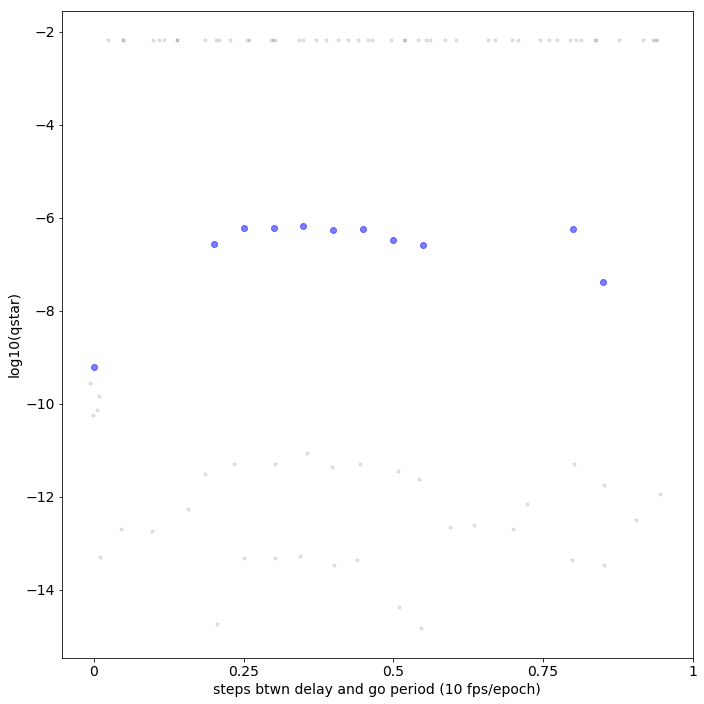

In [37]:
task_list = ['fdgo','fdanti']
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')
# m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1'
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0'
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0'
epoch_set = ['stim1','go1']
epoch = epoch_set[0]
for si in range(20):
    f = get_filename(task_list, 0, si)
#     filename = os.path.join(m,'fixed_pts_stepX_tasks_samesstim',epoch,task_list[0]+'_'+task_list[1],filename+'.npz')
    filename = os.path.join(m,'fixed_pts_stepX_tasks_fwd_stim',epoch,task_list[0]+'_'+task_list[1],f+'.npz')
    fp_struct = np.load(filename)
    plt.plot(si+.2*npr.randn(np.shape(fp_struct['qstar'])[0]),np.log10(fp_struct['qstar']),'.k',alpha = .1)
    plt.plot(si,np.mean(np.log10(fp_struct['qstar'])),'ob',alpha = .5)
    
# plt.ylim([-40,0])  
plt.ylabel('log10(qstar)')
plt.xticks([0,5,10,15,20],[0,.25,.5,.75,1])
plt.xlabel('steps btwn delay and go period (10 fps/epoch)')
plt.show()

In [43]:
t = 0
t_num = t
# task_list = ['fdgo','fdanti']
# m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1'
epoch_set = ['stim1','go1']
epoch = epoch_set[0]
rule = task_list[0]
n_interp = 20
n_fps_init = 60
step_file ='fixed_pts_stepX_tasks_fwd_stim'#,'fixed_pts_stepX_tasks_samesstim'

In [44]:
# m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0'
# m = '/Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0'
# m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1'
# t = 0
# t_num = t
# epoch_set = ['delay1','go1']
# # task_list = ['delaygo','multidelaydm'] 
# epoch = epoch_set[0]
# rule = 'delaygo'
# n_interp = 20
# n_fps_init = 60
# step_file = 'fixed_pts_stepX_tasks_fwd'

def make_X_steps_task(m, step_file, epoch, task_list, n_fps_init, t_num = 0, n_interp = 20):
    
    trial = gen_trials_from_model_dir(m,task_list[0],noise_on = False)
    _,x1 = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    inds_use = [int(x) for x in np.linspace(T_inds[1],x1.shape[2]-1,n_interp)]
    h_tf = x1[:,:,inds_use]
    fp_steps = []

    for step_i in range(n_interp):
        n_fps = n_fps_init

        filename = task_list[0]+'_'+task_list[1]+'_trial_'+str(t_num)+'_step_'+str(step_i)
        filename = os.path.join(m,step_file,epoch,task_list[0]+'_'+task_list[1],filename+'.npz')
        fp_struct = np.load(filename)

        sorted_fps = fp_struct['xstar']
        if np.shape(sorted_fps)[0]>n_fps:
            kmeans = KMeans(n_clusters=n_fps, random_state=0).fit(sorted_fps)
            _,fp_inds = np.unique(kmeans.labels_,return_index=True)
        else: 
            fp_inds = range(np.shape(sorted_fps)[0])

        n_fps = len(fp_inds)
        dst_FP = np.zeros((n_fps))
        for s in range(n_fps):
            dst_FP[s] = LA.norm(h_tf[:,t,step_i] - sorted_fps[fp_inds[s],:])

        sorted_inds = [fp_inds[int(x)] for x in np.argsort(dst_FP)]
        fps_sorted = sorted_fps[sorted_inds,:]

        if fp_steps == []:
            fp_steps = fps_sorted
            num_found = [np.shape(fps_sorted)[0],]
            qstar_vals = fp_struct['qstar'][sorted_inds]
        else:
            fp_steps = np.concatenate((fp_steps, fps_sorted), axis=0)
            num_found = num_found+ [np.shape(fps_sorted)[0],]
            qstar_vals = np.concatenate((qstar_vals,fp_struct['qstar'][sorted_inds]))
            
    X = np.squeeze(fp_steps).astype(np.float64)
    D = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    dst = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    for xi in range(np.shape(X)[0]):
        for yi in range(np.shape(X)[0]):
            D[xi,yi] = LA.norm(X[xi,:]-X[yi,:])
            dst[xi,yi] = distance.euclidean(X[xi,:], X[yi,:])

    embedding = MDS(n_components = 2,dissimilarity = 'precomputed')
    X_steps = embedding.fit_transform(dst)
    
    return X_steps,dst,fp_steps,num_found,qstar_vals

In [45]:
t_num = 0
epoch = 'stim1'
X_steps,D,fp_steps,num_found,qstar_vals = make_X_steps_task(m, step_file, epoch, task_list, n_fps_init, t_num = t_num, n_interp = 20)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Use

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


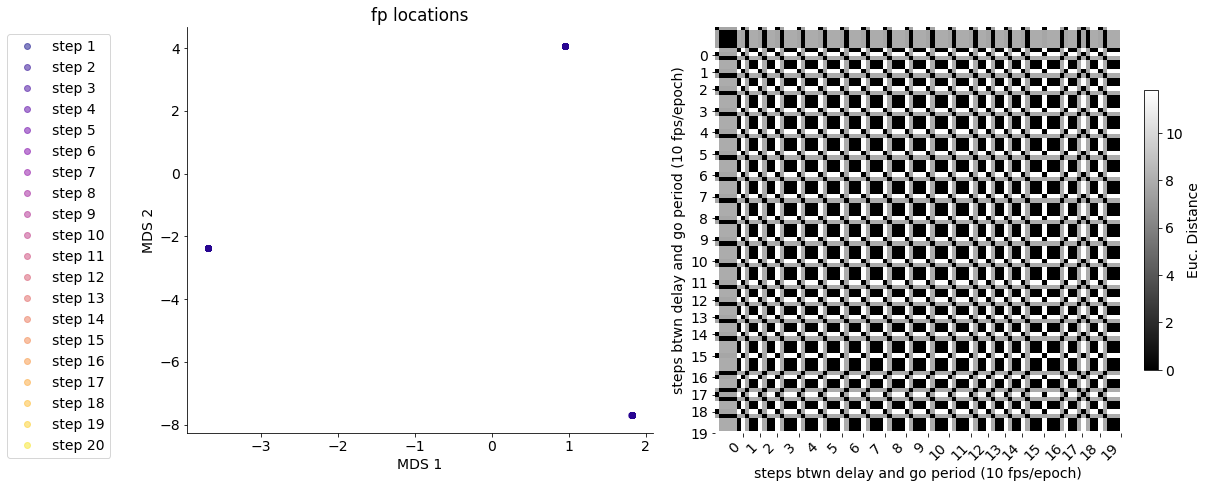

In [46]:
n_fps = n_fps_init
new_names = [str(step_i) for step_i in range(n_interp)]

fig = plt.figure(figsize=(17,7),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 14})

ax1 = plt.subplot(1,2,1)
plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = .5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
legend_set = ['step '+ str(x) for x in range(1,21)]
plt.legend((legend_set),bbox_to_anchor=(-.15, 1))
plt.title('fp locations')

ax2 = plt.subplot(1,2,2)
# n_trials_each = 100
plt.imshow(D,'gray')
tick_locs = num_found#range(int(n_fps/2),n_fps*n_interp,n_fps)
plt.xticks(np.cumsum(num_found),range(len(num_found)),rotation = 45, ha="right", va="top")
plt.yticks(np.cumsum(num_found),range(len(num_found)))
plt.xlabel('steps btwn delay and go period (10 fps/epoch)')
plt.ylabel('steps btwn delay and go period (10 fps/epoch)')

cbar = plt.colorbar(fraction = .03)
cbar.set_label('Euc. Distance')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

figpath = os.path.join(m,'step_btwn_fps_multitasks',step_file)
figname = task_list[0]+'_'+task_list[1]+'trial'+str(t_num)+'_colored_by_step.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


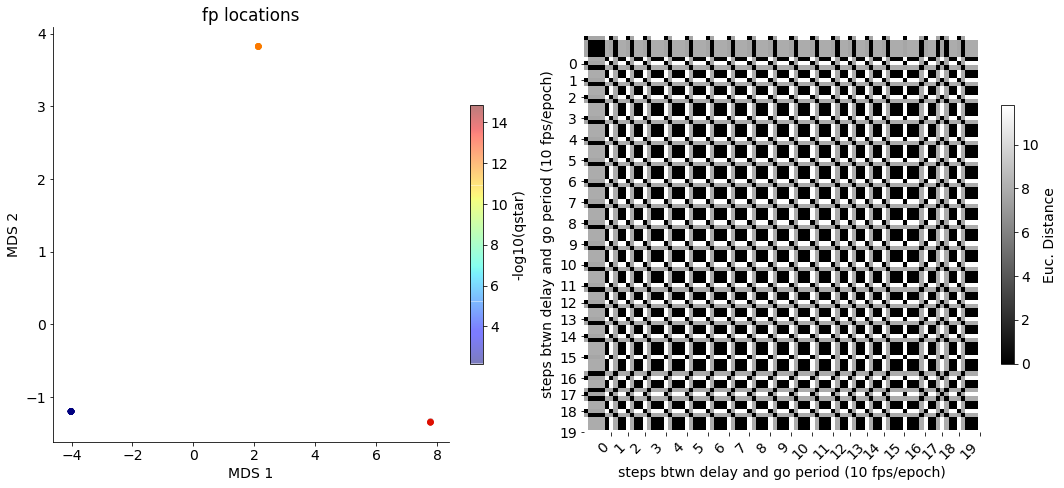

In [19]:
new_names = [str(step_i) for step_i in range(n_interp)]

fig = plt.figure(figsize=(15,7),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 14})

ax1 = plt.subplot(1,2,1)
plot_h_mds_steps_qstar(X_steps,qstar_vals,size = 30)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
cbar = plt.colorbar(fraction = .03)
cbar.set_label('-log10(qstar)')
plt.title('fp locations')

ax2 = plt.subplot(1,2,2)
# n_trials_each = 100
plt.imshow(D,'gray')
tick_locs = num_found#range(int(n_fps/2),n_fps*n_interp,n_fps)
plt.xticks(np.cumsum(num_found),range(len(num_found)),rotation = 45, ha="right", va="top")
plt.yticks(np.cumsum(num_found),range(len(num_found)))
plt.xlabel('steps btwn delay and go period (10 fps/epoch)')
plt.ylabel('steps btwn delay and go period (10 fps/epoch)')

cbar = plt.colorbar(fraction = .03)
cbar.set_label('Euc. Distance')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

figpath = os.path.join(m,'step_btwn_fps_multitasks',step_file)
figname = task_list[0]+'_'+task_list[1]+'trial'+str(t_num)+'_colored_by_log10qval.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [20]:
def get_model_params(m):
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    return w_in, b_in, w_out, b_out

from tools_lnd import out_axes

In [21]:
from tools_lnd import plot_N, TDR_axes

In [22]:
def plot_indep_fps(m,D,rule,fp_epoch,trial,c,add_zero = True):
    cmap=plt.get_cmap('plasma')
    
    if add_zero is True:
        filename = os.path.join(m,'tf_fixed_pts_all_init',rule,fp_epoch+'_'+str(trial)+'.0.npz')
    else:
        filename = os.path.join(m,'golub_fixed_pts',rule,fp_epoch+'_'+str(trial)+'.npz')

    print(filename)
    fp_struct = np.load(filename)
    fps = fp_struct['xstar']
    qs = fp_struct['qstar']

    X_steps = np.dot(fps,D)
    plt.scatter(X_steps[:,0],X_steps[:,1],100,cmap(c*1000),edgecolors='w')
    return

In [23]:
def plot_steps_tasks(m, task_nums, X, qstar_vals, n_interp, n_fps, t_num = 0,  
                     plotN = False, plotN_epoch = 'delay1', plotIFPs = False, add_zero = True):

    task_list = [rules_dict['all'][task_nums[0]], rules_dict['all'][task_nums[1]]]
    trial_set = range(0,80,10)
    
    D1 = make_axes(m,task_list[0],plotN_epoch,ind = -1)
    D2 = make_axes(m,task_list[1],plotN_epoch,ind = -1)
    w_in, b_in, w_out, b_out = get_model_params(m)
    D_go = w_out[:,1:]
    
    fig = plt.figure(figsize=(17, 11))
    
    ax1 = plt.subplot(2,3,1)
    X_steps = np.dot(X,D1)
    plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = .5)
    if plotN:
        trial1 = gen_trials_from_model_dir(m,task_list[0],noise_on = False)
        _,x = gen_X_from_model_dir(m,trial1)
        T_inds = get_T_inds(trial1,plotN_epoch)
        x1 = np.transpose(x[:,:,T_inds],(1,2,0))
        plot_N(x1[trial_set,:,:],D1.T,trial1.y_loc[-1,trial_set])
        
    if plotIFPs:
        for task_num in range(1):
            plot_indep_fps(m,D1,task_list[task_num],plotN_epoch,t_num,task_num,add_zero = add_zero)
    TDR_axes(plotN_epoch,ax1,task_list[0])

    ax2 = plt.subplot(2,3,2)
    X_steps = np.dot(X,D2)
    plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = .5) 
    
    if plotN:
        trial2 = same_stim_trial(trial1, task_nums[1])
        _,x = gen_X_from_model_dir(m,trial2)
        T_inds = get_T_inds(trial2,plotN_epoch)
        x2 = np.transpose(x[:,:,T_inds],(1,2,0))
        plot_N(x2[trial_set,:,:],D2.T,trial2.y_loc[-1,trial_set])
    if plotIFPs:
        for task_num in range(1,2):
            plot_indep_fps(m,D2,task_list[task_num],plotN_epoch,0,task_num,add_zero = add_zero)
    TDR_axes(plotN_epoch,ax2,task_list[1])

    ax3 = plt.subplot(2,3,3)
    X_steps = np.dot(X,D_go)
    plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = .5)
    if plotN:
        plot_N(x1[trial_set,:,:],D_go.T,trial1.y_loc[-1,trial_set])
    out_axes(ax3)
    legend_set = ['step '+ str(x) for x in range(1,21)]
    plt.legend((legend_set),bbox_to_anchor=(1.5, 1))

    ax4 = plt.subplot(2,3,4)
    X_steps = np.dot(X,D1)
    plot_h_mds_steps_qstar(X_steps,qstar_vals,size = 30)
    TDR_axes(plotN_epoch,ax4,task_list[0])

    ax5 = plt.subplot(2,3,5)
    X_steps = np.dot(X,D2)
    plot_h_mds_steps_qstar(X_steps,qstar_vals,size = 30)
    TDR_axes(plotN_epoch,ax5,task_list[1])

    ax6 = plt.subplot(2,3,6)
    X_steps = np.dot(X,D_go)
    plot_h_mds_steps_qstar(X_steps,qstar_vals,size = 30)
    out_axes(ax6)
    axins = inset_axes(ax6,
                   width="5%",  # width = 5% of parent_bbox width
                   height="70%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(2.3, -1.2, 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )

    cbar = plt.colorbar(cax = axins)
    cbar.set_label('-log10(qstar)',rotation = 90)
    return

In [24]:
def make_axes(m,rule_master,epoch,ind = -1,mod = 'either'):

    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        trial_master = generate_trials(rule_master, hparams, mode = 'test', batch_size = 400, noise_on=False, delay_fac =1)
        feed_dict = tools.gen_feed_dict(model, trial_master, hparams)
        h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)

    print(mod)
    Beta_epoch = generate_Beta_epoch(h_tf,trial_master,ind,mod = mod)
    X_pca = Beta_epoch[epoch]    
    D = np.concatenate((np.expand_dims(X_pca[:,0],axis=1),np.expand_dims(X_pca[:,1],axis=1)),axis = 1)
    return D

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
either
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters fr

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


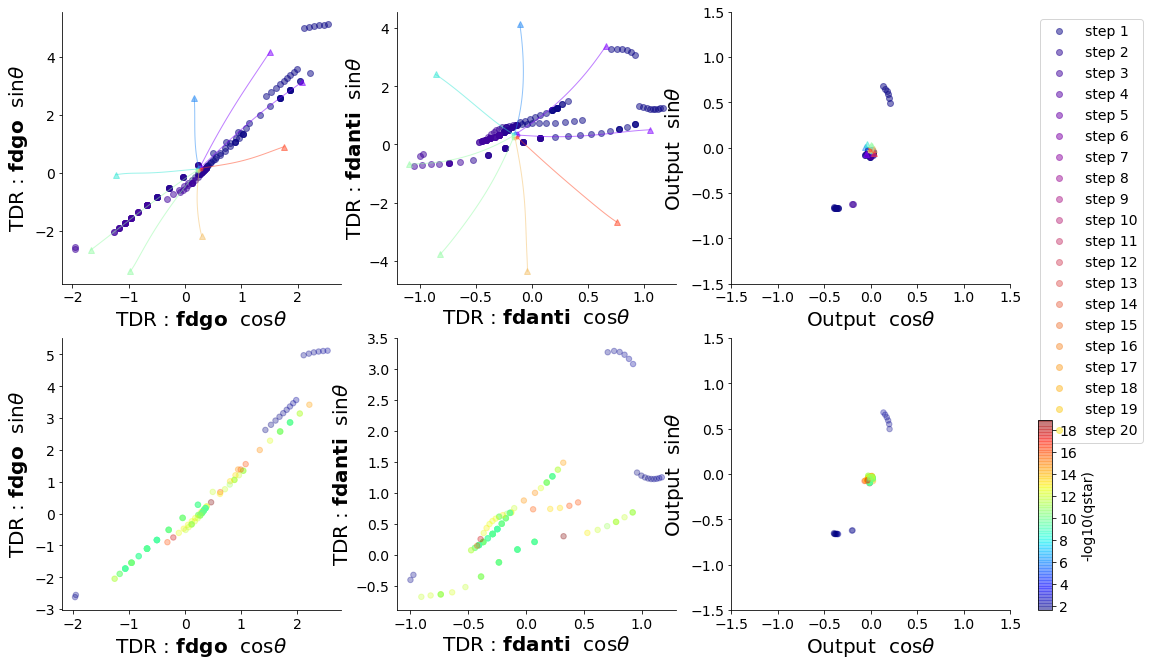

In [36]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
X = np.squeeze(fp_steps).astype(np.float64)
plot_steps_tasks(m,[0,3],X,qstar_vals,n_interp,n_fps,plotN = True, plotN_epoch = 'stim1',
                plotIFPs = False, add_zero = True)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/0/model.ckpt
either
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters fr

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


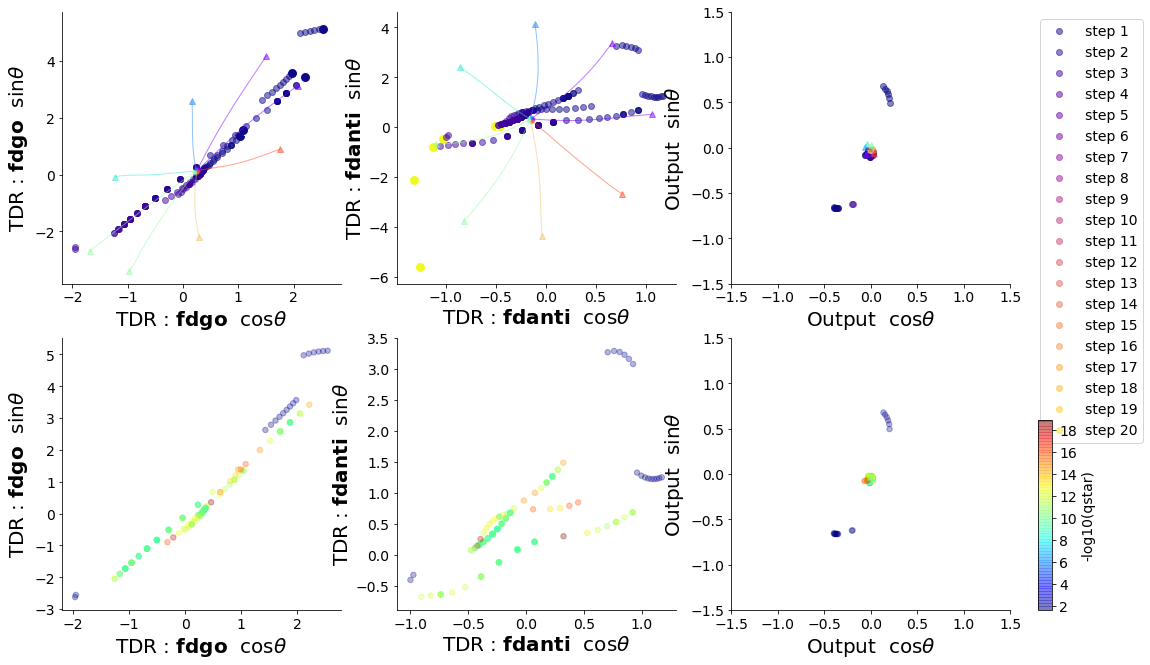

In [35]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
X = np.squeeze(fp_steps).astype(np.float64)
plot_steps_tasks(m,[0,3],X,qstar_vals,n_interp,n_fps,plotN = True, plotN_epoch = 'stim1',
                plotIFPs = True, add_zero = True)

In [110]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1'

In [116]:
task_list = ['fdanti','fdgo']
stim_list = [180,0]

task_list = ['fdgo','fdanti']
stim_list = [0,180]

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
either


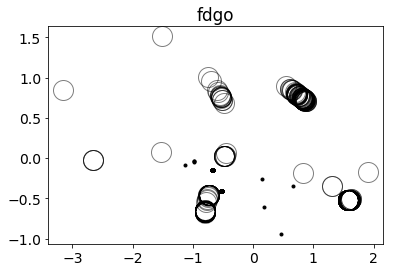

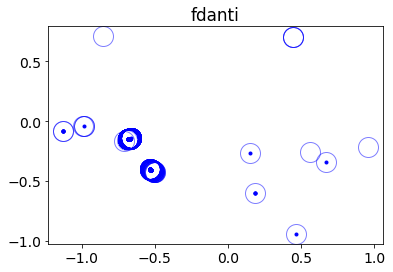

In [117]:
epoch = 'stim1'
D = make_axes(m,task_list[0],epoch,ind = -1)
t_num = 0
color_set = ['k','b']

for ri in range(2):

    filename = os.path.join(m,'tf_fixed_pts_all_init',task_list[ri],epoch+'_'+str(stim_list[ri])+'.0.npz')
    fp_struct = np.load(filename)
    fps = fp_struct['xstar']
    qs = fp_struct['qstar']
    X_steps = np.dot(fps,D)
    plt.plot(X_steps[:,0],X_steps[:,1],'o'+color_set[ri],markerfacecolor = 'None',markersize = 20,alpha = .5)

    f = get_filename(task_list, 0, ri)
#     filename = os.path.join(m,'fixed_pts_stepX_tasks_samesstim',epoch,task_list[0]+'_'+task_list[1],f+'.npz')
    filename = os.path.join(m,'fixed_pts_stepX_tasks_fwd_stim',epoch,task_list[0]+'_'+task_list[1],f+'.npz')
    fp_struct = np.load(filename)
    fps = fp_struct['xstar']
    qs = fp_struct['qstar']
    X_steps = np.dot(fps,D)
    plt.plot(X_steps[:,0],X_steps[:,1],'.'+color_set[ri])
    
    plt.title(task_list[ri])
    plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplu

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


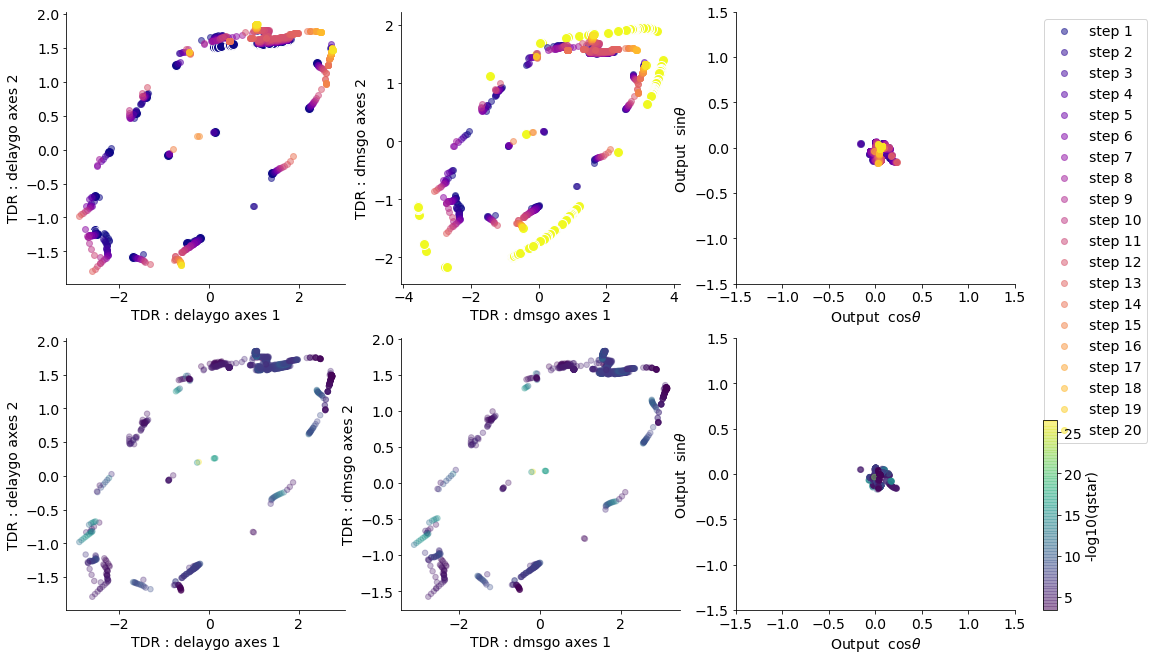

In [85]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
X = np.squeeze(fp_steps).astype(np.float64)
plot_steps_tasks(m,task_list,X,qstar_vals,n_interp,n_fps,plotN = False, plotN_epoch = 'delay1',
                plotIFPs = True, add_zero = False)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplu

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


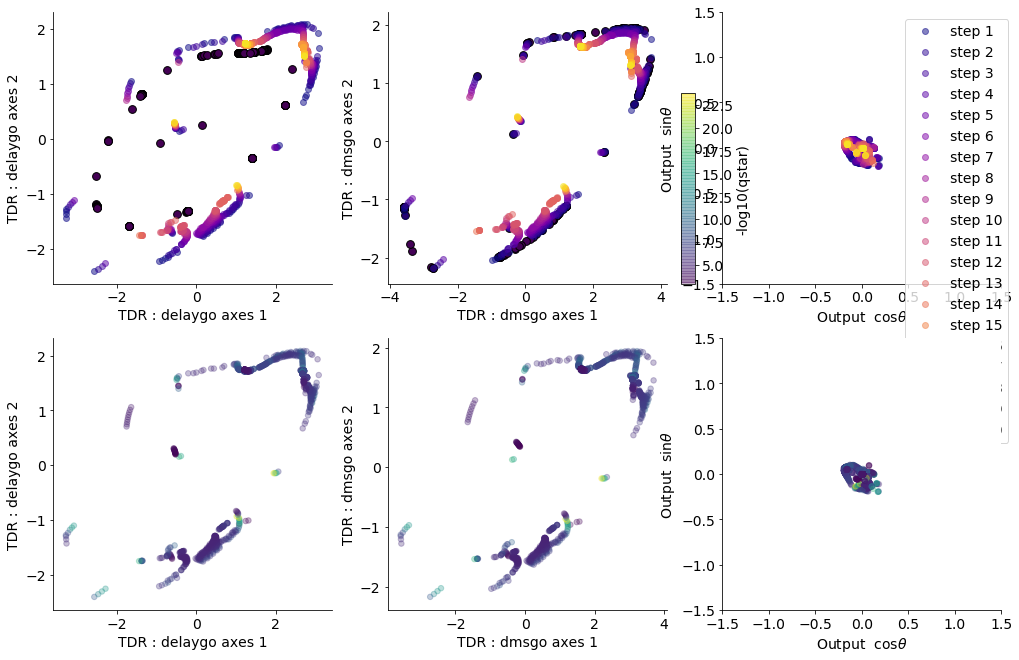

In [33]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
X = np.squeeze(fp_steps).astype(np.float64)
plot_steps_tasks(m,task_list,X,qstar_vals,n_interp,n_fps,plotN = False, plotN_epoch = 'delay1',
                plotIFPs = True, add_zero = False)

# figpath = os.path.join(m,'step_btwn_fps_multitasks',step_file)
# figname = task_list[0]+'_'+task_list[1]+'_colored_by_both.pdf'
# if not os.path.exists(figpath):
#     os.makedirs(figpath)
# plt.savefig(os.path.join(figpath,figname))
# plt.show()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
X = np.squeeze(fp_steps).astype(np.float64)
plot_steps_tasks(m,task_list,X,qstar_vals,n_interp,n_fps,plotN = False, plotN_epoch = 'delay1',
                plotIFPs = True, add_zero = True)

# figpath = os.path.join(m,'step_btwn_fps_multitasks',step_file)
# figname = task_list[0]+'_'+task_list[1]+'_colored_by_both.pdf'
# if not os.path.exists(figpath):
#     os.makedirs(figpath)
# plt.savefig(os.path.join(figpath,figname))
# plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l

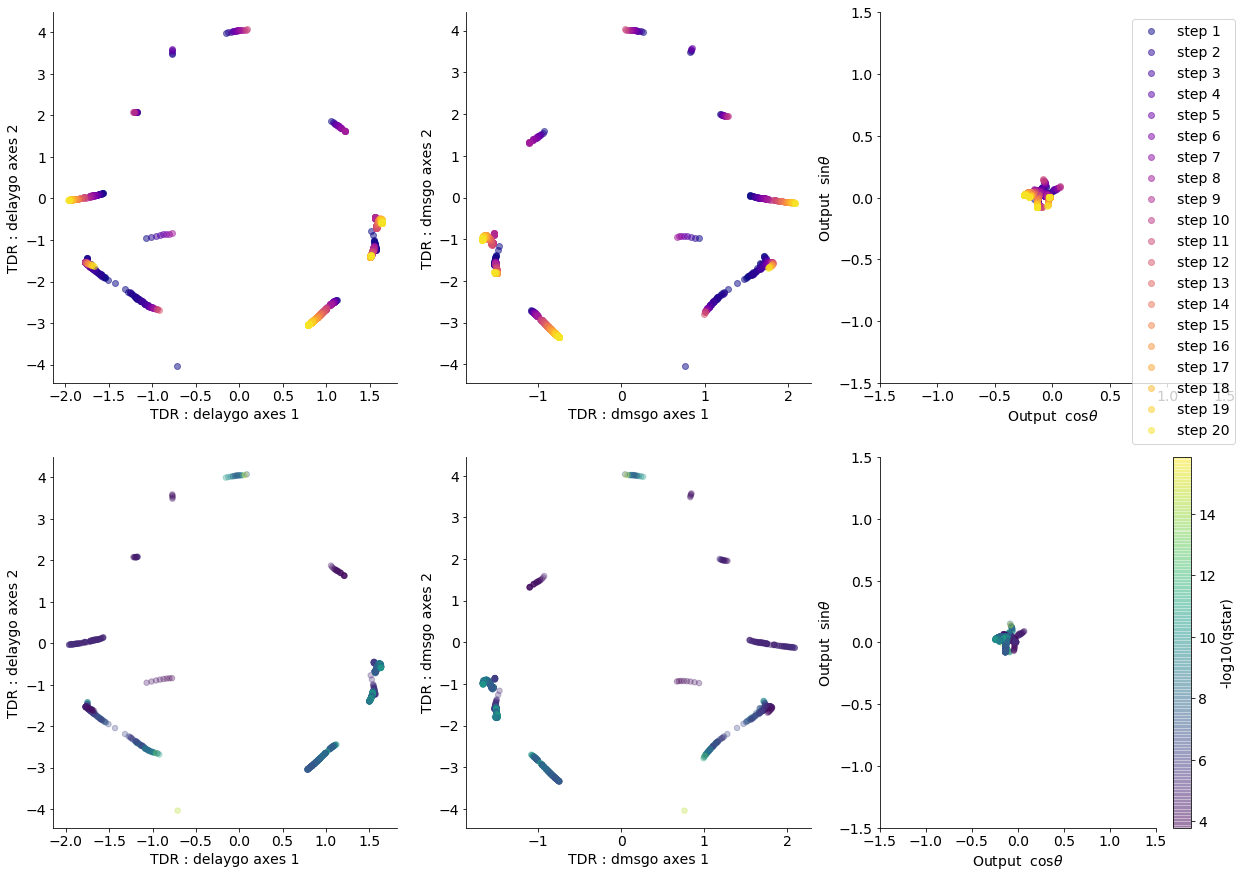

In [30]:
plot_steps_tasks(m,task_list,X,qstar_vals,n_interp,n_fps,plotN = False,plotIFPs = True)

In [107]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1'

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l

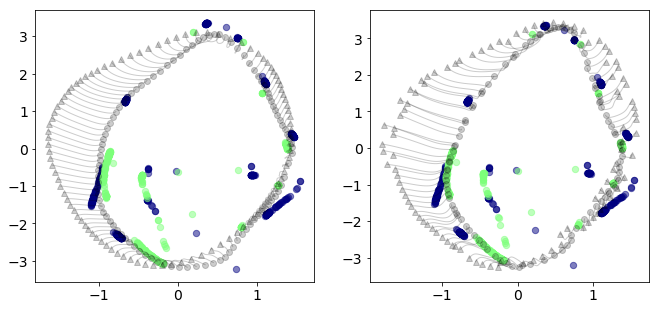

In [113]:
fp_epoch = 'delay1'
task_list = ['delaygo','dmsgo']
from tools_lnd import align_output_inds

D1 = make_axes(m,task_list[0],fp_epoch,ind = 0)
trial_master = gen_trials_from_model_dir(m,task_list[0],noise_on = False)
cmap=plt.get_cmap('jet')

fig = plt.figure(figsize=(11, 5))
for ri in range(len(task_list)):

    filename = os.path.join(m,'tf_fixed_pts_all_init',task_list[ri],fp_epoch+'_'+str(0)+'.0.npz')
    print(filename)
    fp_struct = np.load(filename)
    fps = fp_struct['xstar']
    qs = fp_struct['qstar']

    X_steps = np.dot(fps,D1)
    
    plt.subplot(1,2,1)
    plt.scatter(X_steps[:,0],X_steps[:,1],40,cmap(ri/len(task_list)),alpha = .5,cmap = 'jet')
    plt.subplot(1,2,2)
    plt.scatter(X_steps[:,0],X_steps[:,1],40,cmap(ri/len(task_list)),alpha = .5,cmap = 'jet')
    
    if ri>0:
        trial = gen_trials_from_model_dir(model_dir_all,task_list[ri],mode='test',
                                          noise_on = False,batch_size = 2000)
        trial = align_output_inds(trial_master, trial)
    else:
        trial = trial_master
        
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,fp_epoch)
    x1 = np.transpose(x[:,:,T_inds],(1,2,0))
    
    if np.shape(x1)[0]>100:
        trial_set = range(0,np.shape(x1)[0],int(np.shape(x1)[0]/100))
    
    plt.subplot(1,2,ri+1)
    X = x1[trial_set,:,:]
    D = D1.T
    S = np.shape(X)[0]
    c = 'k'
    
    for s in range(S):
        X_trial = np.dot(X[s,:,:],D.T)
        plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = 1, alpha = .2)
        plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1, alpha = .2)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = 1, alpha = .2)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/model.ckpt
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l

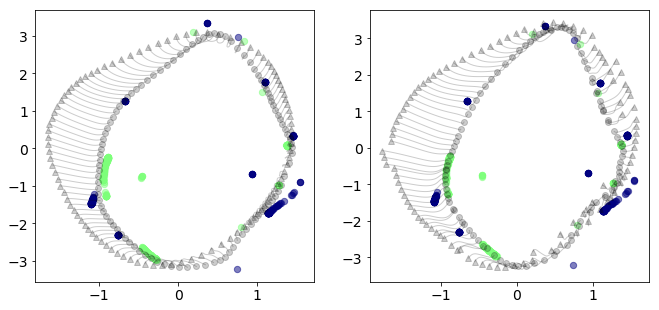

In [114]:
fp_epoch = 'delay1'
task_list = ['delaygo','dmsgo']
from tools_lnd import align_output_inds

D1 = make_axes(m,task_list[0],fp_epoch,ind = 0)
trial_master = gen_trials_from_model_dir(m,task_list[0],noise_on = False)
cmap=plt.get_cmap('jet')

fig = plt.figure(figsize=(11, 5))
for ri in range(len(task_list)):

    filename = os.path.join(m,'golub_fixed_pts',task_list[ri],fp_epoch+'_'+str(0)+'.0.npz')
    print(filename)
    fp_struct = np.load(filename)
    fps = fp_struct['xstar']
    qs = fp_struct['qstar']

    X_steps = np.dot(fps,D1)
    
    plt.subplot(1,2,1)
    plt.scatter(X_steps[:,0],X_steps[:,1],40,cmap(ri/len(task_list)),alpha = .5,cmap = 'jet')
    plt.subplot(1,2,2)
    plt.scatter(X_steps[:,0],X_steps[:,1],40,cmap(ri/len(task_list)),alpha = .5,cmap = 'jet')
    
    if ri>0:
        trial = gen_trials_from_model_dir(model_dir_all,task_list[ri],mode='test',
                                          noise_on = False,batch_size = 2000)
        trial = align_output_inds(trial_master, trial)
    else:
        trial = trial_master
        
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,fp_epoch)
    x1 = np.transpose(x[:,:,T_inds],(1,2,0))
    
    if np.shape(x1)[0]>100:
        trial_set = range(0,np.shape(x1)[0],int(np.shape(x1)[0]/100))
    
    plt.subplot(1,2,ri+1)
    X = x1[trial_set,:,:]
    D = D1.T
    S = np.shape(X)[0]
    c = 'k'
    
    for s in range(S):
        X_trial = np.dot(X[s,:,:],D.T)
        plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = 1, alpha = .2)
        plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1, alpha = .2)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = 1, alpha = .2)

In [106]:
fp_epoch = 'delay1'
task_list = ['delaygo','dmsgo']
from tools_lnd import align_output_inds

D1 = make_axes(m,task_list[0],fp_epoch,ind = 0)
trial_master = gen_trials_from_model_dir(m,task_list[0],noise_on = False)
cmap=plt.get_cmap('tab10')

fig = plt.figure(figsize=(11, 5))
for ri in range(len(task_list)):

    filename = os.path.join(m,'tf_fixed_pts_all_init',task_list[ri],fp_epoch+'_'+str(0)+'.npz')
    print(filename)
    fp_struct = np.load(filename)
    fps = fp_struct['xstar']
    qs = fp_struct['qstar']
    
    cvals = -np.log10(fp_struct['qstar'])
    cvals_lims = cvals
    cvals_lims[cvals_lims<4] = 4
    cvals_lims[cvals_lims>12] = 12

    X_steps = np.dot(fps,D1)
    
    plt.subplot(1,2,1)
    plt.scatter(X_steps[:,0],X_steps[:,1],40,cvals_lims,alpha = .5,cmap = 'jet')
    plt.subplot(1,2,2)
    plt.scatter(X_steps[:,0],X_steps[:,1],40,cvals_lims,alpha = .5,cmap = 'jet')
    plt.colorbar()
    
    if ri>0:
        trial = gen_trials_from_model_dir(model_dir_all,task_list[ri],mode='test',
                                          noise_on = False,batch_size = 2000)
        trial = align_output_inds(trial_master, trial)
    else:
        trial = trial_master
        
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,fp_epoch)
    x1 = np.transpose(x[:,:,T_inds],(1,2,0))
    
    if np.shape(x1)[0]>100:
        trial_set = range(0,np.shape(x1)[0],int(np.shape(x1)[0]/100))
    
    plt.subplot(1,2,ri+1)
    plot_N(x1[trial_set,:,:],D1.T,np.ones(np.shape(trial_set)))#trial.y_loc[-1,trial_set])

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
either
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplu

IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/tf_fixed_pts_all_init/delaygo/delay1_0.npz'

<Figure size 792x360 with 0 Axes>

In [ ]:
fp_epoch = 'delay1'
task_list = ['delaygo','dmsgo']
epoch_list = ['fix1','delay1']

D1 = make_axes(m,task_list[1],fp_epoch,ind = 0)
trial_master = gen_trials_from_model_dir(m,task_list[1])
cmap=plt.get_cmap('tab10')

fig = plt.figure(figsize=(11, 5))
for ri in range(len(epoch_list)):
    
    rule = task_list[1]
    epoch = epoch_list[ri]

    filename = os.path.join(m,'golub_fixed_pts',rule,epoch+'_'+str(0)+'.npz')
    print(filename)
    fp_struct = np.load(filename)
    fps = fp_struct['xstar']
    qs = fp_struct['qstar']

    X_steps = np.dot(fps,D1)
    
    plt.subplot(1,2,1)
    plt.scatter(X_steps[:,0],X_steps[:,1],40,cmap(ri/len(epoch_list)),alpha = .5)
    plt.subplot(1,2,2)
    plt.scatter(X_steps[:,0],X_steps[:,1],40,cmap(ri/len(epoch_list)),alpha = .5)
    
#     if ri>0:
#         trial = gen_trials_from_model_dir(model_dir_all,task_list[ri],mode='test',noise_on = False,batch_size = 2000)
#         trial = align_output_inds(trial_master, trial)
#     else:
#         trial = trial_master

    trial = trial_master
        
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,fp_epoch)
    x1 = np.transpose(x[:,:,T_inds],(1,2,0))
    
    plt.subplot(1,2,ri+1)
    plot_N(x1[trial_set,:,:],D1.T,trial.y_loc[-1,trial_set])

In [ ]:
X = np.squeeze(fp_steps).astype(np.float64)

fig = plt.figure(figsize=(11, 10))
ax1 = plt.subplot(2,2,1)
X_steps = np.dot(X,D_delay)
plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = .5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.xlabel('TDR : delay axes 1')
plt.ylabel('TDR : delay axes 2')

ax2 = plt.subplot(2,2,2)
X_steps = np.dot(X,D_go)
plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = .5)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.legend((['step 1','step 2','step 3','step 4','step 5','step 6','...']),bbox_to_anchor=(1.5, .5))
plt.xlabel('TDR : go axes 1')
plt.ylabel('TDR : go axes 2')

ax1 = plt.subplot(2,2,3)
X_steps = np.dot(X,D_delay)
plot_h_mds_steps_qstar(X_steps,qstar_vals,size = 30)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.xlabel('TDR : delay axes 1')
plt.ylabel('TDR : delay axes 2')

ax2 = plt.subplot(2,2,4)
X_steps = np.dot(X,D_go)
plot_h_mds_steps_qstar(X_steps,qstar_vals,size = 30)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.colorbar()
plt.xlabel('TDR : go axes 1')
plt.ylabel('TDR : go axes 2')

In [ ]:
from tools_lnd import gen_trials_from_model_dir,gen_X_from_model_dir_epoch

PCS = {}
npcs_rule = {}
epoch_list = ['fix1','stim1','delay1','go1']
nc = len(epoch_list)
nr = 1
ckpt_n = name_best_ckpt(m,rule)
ckpt_n_dir = os.path.join(m,'ckpts/model.ckpt-' + str(int(ckpt_n)))
fig = plt.figure(figsize=(5*nc, 5*nr))

for ei in range(len(epoch_list)):
    epoch = epoch_list[ei]
    ax = plt.subplot(1,len(epoch_list),ei+1) 
    pca = PCA(n_components = 20)
    
    trial = gen_trials_from_model_dir(m,rule,mode='random',noise_on = False,batch_size = 500)
    X, x = gen_X_from_model_dir_epoch(m,ckpt_n_dir,trial,epoch)
    _ = pca.fit_transform(x[:,:,-1])
    PCS[rule] = pca.components_
    
    var_lim = .99
    frac_ev = np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_)
    npcs_rule[rule] = np.argmax(frac_ev>var_lim)+1
    
    plt.plot(frac_ev,'o-k',alpha = .5)
    plt.plot([np.argmax(frac_ev>var_lim),np.argmax(frac_ev>var_lim)],[0,1])
    plt.text(np.argmax(frac_ev>var_lim)+1,0,str(var_lim*100)+'% var @PC '+str(np.argmax(frac_ev>var_lim)))

    plt.title(rule + ' : ' + epoch)
    if ei==0:
        plt.ylabel('Cumulative Variance Explained')
        plt.xlabel('Number of PCs')
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.show()

In [ ]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0'
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0'
# m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1'
t = 0
t_num = t
epoch_set = ['delay1','go1']
rule = 'delaygo'
n_interp = 20
n_fps = 30

trial = gen_trials_from_model_dir(m,rule)
_,x2 = gen_X_from_model_dir(m,trial)
T_inds = get_T_inds(trial,epoch_set[0])
inds_use = [int(x) for x in np.linspace(T_inds[1],x2.shape[2]-1,n_interp)]
h_tf = x2[:,:,inds_use]
fp_steps = []

step_i = 0
n_fps = 30

filename = get_filename(epoch_set, t, step_i)
filename = os.path.join(m,'fixed_pts_stepX_fwd',rule,filename+'.npz')
fp_struct = np.load(filename)

sorted_fps = fp_struct['xstar']

In [ ]:
w_in, b_in, w_out, b_out = get_model_params(m)
D_go = w_out[:,1:]

In [ ]:
plt.plot(abs(np.dot(sorted_fps,D_go)),'.')

In [ ]:
np.sum(abs(np.dot(sorted_fps,D_go))>.4,axis = 1)

In [ ]:
perimeter_fps = np.argwhere(np.sum(abs(np.dot(sorted_fps,D_go))>.4,axis = 1))

In [ ]:
ax = plt.subplot(1,1,1)
fp_out_axes = np.dot(sorted_fps,D_go)
plt.plot(fp_out_axes[:,0],fp_out_axes[:,1],'ok')
plt.plot(fp_out_axes[perimeter_fps,0],fp_out_axes[perimeter_fps,1],'or')
out_axes(ax)

In [ ]:
def plot_FP(X, D, eig_decomps, c='k'):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    S = np.shape(X)[0]
    lf = 1
    rf = 1
    
    for s in range(S):
        
        X_trial = np.dot(X[s,:],D.T)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']>1)+1
        if len(n_arg)>0:
            for arg in range(np.max(n_arg)):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2],'k',alpha = .5,linewidth = .5)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']<.3)
        if len(n_arg)>0:
            for arg in range(np.min(n_arg),len(eig_decomps[s]['evals'])):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2],'b',alpha = .5,linewidth = .5)
            
        plt.plot(X_trial[0], X_trial[1], 'o', markerfacecolor = c, markeredgecolor = 'k', 
                 markersize = 6, alpha = .5)
        
def plot_FP_specific(s,X, D, eig_decomps, c='k'):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    lf = 1000
    rf = 1000
    
    X_trial = np.dot(X[s,:],D.T)
        
    n_arg = np.argwhere(eig_decomps[s]['evals']>1)+1
    if len(n_arg)>0:
        for arg in range(np.max(n_arg)):
            rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
            ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
            overlap = np.dot(rdots,ldots.T)
            r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
            plt.plot(r[0:4:2],r[1:4:2],'k',alpha = .5,linewidth = .5)

    n_arg = np.argwhere(eig_decomps[s]['evals']<.3)
    if len(n_arg)>0:
        for arg in range(np.min(n_arg),len(eig_decomps[s]['evals'])):
            rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
            ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
            overlap = np.dot(rdots,ldots.T)
            r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
            plt.plot(r[0:4:2],r[1:4:2],'b',alpha = .5,linewidth = .5)

    plt.plot(X_trial[0], X_trial[1], 'o', markerfacecolor = 'none', markeredgecolor = c, 
             markersize = 20, alpha = .5)

In [ ]:
def comp_eig_decomp(Ms, sort_by='real',
                                     do_compute_lefts=True):
  """Compute the eigenvalues of the matrix M. No assumptions are made on M.

  Arguments: 
    M: 3D np.array nmatrices x dim x dim matrix
    do_compute_lefts: Compute the left eigenvectors? Requires a pseudo-inverse 
      call.

  Returns: 
    list of dictionaries with eigenvalues components: sorted 
      eigenvalues, sorted right eigenvectors, and sored left eigenvectors 
      (as column vectors).
  """
  if sort_by == 'magnitude':
    sort_fun = np.abs
  elif sort_by == 'real':
    sort_fun = np.real
  else:
    assert False, "Not implemented yet."      
  
  decomps = []
  L = None  
  for M in Ms:
    evals, R = LA.eig(M)    
    indices = np.flipud(np.argsort(sort_fun(evals)))
    if do_compute_lefts:
      L = LA.pinv(R).T  # as columns      
      L = L[:, indices]
    decomps.append({'evals' : evals[indices], 'R' : R[:, indices],  'L' : L})
  
  return decomps

In [ ]:
eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][:,:,:]) 

In [ ]:
plot_FP(sorted_fps, D_go.T, eig_decomps, c='k')

In [ ]:
plot_FP(sorted_fps, D_delay.T, eig_decomps, c='k')

In [ ]:
perimeter_fps

In [ ]:
from tools_lnd import out_axes
cmap=plt.get_cmap('tab20')
eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][:,:,:])

S = len(fp_inds)
xs = np.linspace(-1, 1, 1000)
ys = np.sqrt(1 - xs**2)


for si in perimeter_fps:
    fig = plt.figure(figsize=(10,5),tight_layout=True,facecolor='white')
    s = fp_inds[si]

    ax = plt.subplot(1,2,1)
    plt.plot(eig_decomps[s]['evals'].real,eig_decomps[s]['evals'].imag,'.',c = cmap(si/S))
    plt.plot(xs, ys,':k')
    plt.plot(xs, -ys,':k')
    plt.ylim((-.3,.3))    
    plt.xlim((.5,1.2))

    plt.title(str(s)+ ' : ' + str(fp_struct['qstar'][s]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
    
    ax = plt.subplot(1,2,2)
    plot_FP(sorted_fps, D_go.T, eig_decomps, c='k')
    plot_FP_specific(s,sorted_fps, D_go.T, eig_decomps, c='r')
    out_axes(ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
    
    plt.show()

In [ ]:
from tools_lnd import plot_FP_jitter, vanilla_run_with_h0, TDR_axes

In [ ]:
fp_epoch = 'delay1'
t_num = 0
perimeter_fps = np.argwhere(np.sum(abs(np.dot(sorted_fps,D_go))>.5,axis = 1))
fp_inds = perimeter_fps.flatten()
rule_set = [rule,]

In [ ]:
fig = plt.figure(figsize=(10,5),tight_layout=True,facecolor='white')

ax = plt.subplot(1,2,1)
plot_FP_jitter(m,D_delay,rule,t_num,fp_epoch,sorted_fps,fp_inds,rule_set,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.05,n_steps = 50,
                   lw = 3,al = .6,linestyle = '-',n_jit = 30)
TDR_axes(fp_epoch,ax) 

ax = plt.subplot(1,2,2)
plot_FP_jitter(m,D_go,rule,t_num,fp_epoch,sorted_fps,fp_inds,rule_set,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.05,n_steps = 50,
                   lw = 3,al = .6,linestyle = '-',n_jit = 30)
out_axes(ax)

In [ ]:
center_fps = np.argwhere(np.min(abs(np.dot(sorted_fps,D_go))<.5,axis = 1))
fp_inds = center_fps.flatten()

fig = plt.figure(figsize=(10,5),tight_layout=True,facecolor='white')

ax = plt.subplot(1,2,1)
plot_FP_jitter(m,D_delay,rule,t_num,fp_epoch,sorted_fps,fp_inds,rule_set,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.05,n_steps = 50,
                   lw = 3,al = .6,linestyle = '-',n_jit = 30)
TDR_axes(fp_epoch,ax)

ax = plt.subplot(1,2,2)
plot_FP_jitter(m,D_go,rule,t_num,fp_epoch,sorted_fps,fp_inds,rule_set,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.05,n_steps = 50,
                   lw = 3,al = .6,linestyle = '-',n_jit = 30)
out_axes(ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 